# Predicción de fuga de clientes (Customer Churn Prediction) aplicando técnicas de Machine Learning

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

#Option to display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Estadísticos
# ==============================================================================
from scipy.stats import kurtosis, skew, stats
from math import sqrt
from numpy import mean, var
from fitter import Fitter

# Varios
# ==============================================================================
from pandas_profiling import ProfileReport

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
import os
warnings.filterwarnings('ignore')

# Análisis exploratorio

Preevio a comenzar a importar los datos en nuestro notebook, creamos una serie de funciones que nos servirán para el análisis de los mismos.

In [2]:
# Muestra el directorio en donde esta nuestro proyecto
os.getcwd()

# Cambia la ruta a 1 directorio atras de la actual
os.chdir('../')
# Crea la variable 'path' con la ruta que contiene la data para el análisis
path = os.getcwd() + '\data'
print(f'\nLa ruta de donde se leen los datos a analizar se encuentra en {path}')

# Funciones para tratamiento de datos
# ==============================================================================

# Esta funcion lee el archivo csv indicado dentro de la carpeta data
def read_data():
    temp_df = pd.read_csv(path + '\\insurance.csv')#Cambiar el nombre de archivo que se vaya a analizar
    return temp_df

# Renombra las columnas indicadas 
def normalize_column_names(temp_df):
    return temp_df.rename(columns={"age":"edad",
                                   "sex":"sexo",
                                   "bmi":"imc",
                                   "steps":"pasos",
                                   "children":"hijos",
                                   "smoker":"fumador",
                                   "charges":"cargos",
                                   "insuranceclaim":"fugas"})

# Borra columnas no deseadas en el dataframe
def drop_noisy_columns(temp_df):
    return temp_df.drop(columns=[" "])

# Cambia los tipos de datos
def normalize_dtypes(temp_df):
    return temp_df.astype({" ": bool, " ": str})

# Ordena los datos de acuerdo a determinada columna
def sort_uni_ranking(temp_df):
    return temp_df.sort_values(by=" ")




La ruta de donde se leen los datos a analizar se encuentra en D:\Dev\ML\data


In [3]:
#dataframe de muestra
raw = pd.read_csv('D:\Dev\ML\data\insurance_churn\insurance.csv')
temp = raw.rename(columns={"insuranceclaim":"churns"})
    
temp.head()

,age,sex,bmi,children,smoker,region,charges,churns
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


## Importando los datos

Antes de proceder a estimar o entrenar cualquier modelo predictivo, o incluso antes de realizar cualquier cálculo con un nuevo conjunto de datos, es de vital importancia el proceso de exploración descriptiva de los mismos. Esta metodología permite entender de una mejor manera la información a la que nos enfrentamos en nuestro análisis, así como el contenido y el tipo de cada variable, así como también es posible detectar errores presentes en los datos, como por ejemplo:

Que una columna se haya almacenado de forma incorrecta (una variable numérica siendo reconocida como texto o viceversa).
Que una variable contenga valores que no tienen sentido (por ejemplo, para indicar que no se dispone del precio de una vivienda se introduce el valor 0 o un espacio en blanco).
Que en una variable numérica se haya introducido una palabra en lugar de un número.

Además, este análisis previo nos puede dar pistas sobre qué variables son adecuadas como predictores en un modelo.


In [4]:
# Se hace uso de las funciones anteriormente creadas para este fin
df = (read_data() #lee los datos
     .pipe(normalize_column_names)) #normaliza los nombres de columna

df.columns

Index(['edad', 'sexo', 'imc', 'pasos', 'hijos', 'fumador', 'region', 'cargos',
       'fugas'],
      dtype='object')

In [5]:
# Descripcion de la forma (shape) de nuestro dataset
print(f'Dimensiones del dataset: \nNumero de filas del conjunto de datos: {df.shape[0]} filas \nNumero de columnas del conjunto de datos: {df.shape[1]} columnas')
df.head()

Dimensiones del dataset: 
Numero de filas del conjunto de datos: 1338 filas 
Numero de columnas del conjunto de datos: 9 columnas


,edad,sexo,imc,pasos,hijos,fumador,region,cargos,fugas
0,19,0,27.900,3009,0,1,3,16884.92400,1
1,18,1,33.770,3008,1,0,2,1725.55230,1
2,28,1,33.000,3009,3,0,2,4449.46200,0
3,33,1,22.705,10009,0,0,1,21984.47061,0
4,32,1,28.880,8010,0,0,1,3866.85520,1


## Tipo de cada columna

En esta pieza de código se hace uso de la función info() sobre el dataset almacenado en el paso anterior en la variable de nombre df. El resultado nos arroja información relacionada a cada una de las columnas de los datos en análisis, el RangeIndex coincide con el resultado de el code snippet anterior, donde teníamos 1338 filas, y Data columns debería coincidir con el número total de columnas del dataset.
En la tabla también puede notarse que el conteo total de valores nulos (Non-Null Count) para cada columna es igual al número total de filas, por lo tanto podemos deducir que el dataset no cuenta con valores nulos.
En cuanto a los tipos de datos (columna Dtype) contamos solo con valores numéricos enteros (int64) y decimales (float64).

In [6]:
# Tipo de cada columna
# ==============================================================================
# Non-Null Count hace referencia
# al conteo total de valores no nulos
# dtypes al tipo de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   edad     1338 non-null   int64  
 1   sexo     1338 non-null   int64  
 2   imc      1338 non-null   float64
 3   pasos    1338 non-null   int64  
 4   hijos    1338 non-null   int64  
 5   fumador  1338 non-null   int64  
 6   region   1338 non-null   int64  
 7   cargos   1338 non-null   float64
 8   fugas    1338 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 94.2 KB


In [7]:
#df = datos.copy()
#df.insert(1,'precio_dls',df.apply(lambda x: "{:,}".format(x['precio']), axis=1))
#df.insert(5,'precio_terreno_dls',df.apply(lambda x: "{:,}".format(x['precio_terreno']), axis=1))
#df.head()

### Diccionario de datos


  * edad: edad del titular de la póliza 
  * sexo: género titular de la póliza (femenino=0, masculino=1)
  * imc: Índice de masa corporal, que proporciona una comprensión del cuerpo, pesos relativamente altos o bajos en      relación con la altura, índice objetivo de peso corporal (kg / m ^ 2) utilizando la relación entre la altura y el peso, idealmente 18,5 a 25
  * pasos: pasos de caminata promedio por día del asegurado
  * hijos: número de hijos / dependientes del asegurado
  * fumador: estado de tabaquismo del asegurado (no fumador = 0; fumador = 1)
  * region: el área residencial del asegurado en los EE. UU. (northeast=0, northwest=1, southeast=2, southwest=3)
  * cargos: costos médicos individuales facturados por el seguro médico
  * fugas: si=1, no=0

También podemos chequear los tipos de datos de nuestro dataframe, aplicando la funcion _dtypes_ de pandas

In [8]:
df.dtypes

edad         int64
sexo         int64
imc        float64
pasos        int64
hijos        int64
fumador      int64
region       int64
cargos     float64
fugas        int64
dtype: object

### Número de observaciones y valores ausentes

En conjunto con el estudio del tipo de datos (variables), resulta un factor clave conocer el número de observaciones de las que disponemos y si todas ellas están completas. Los valores ausentes son por demás importantes a la hora de crear modelos predictivos, ya que la mayoría de los algoritmos utilizados para estos fines no aceptan observaciones incompletas o bien se ven muy influenciados por ellas. 
Las labores de imputación de valores ausentes forma parte de la fase de preprocesamiento y, por lo tanto, toda identificación y posterior imputación en los datos (en caso de existir valores ausentes) debe realizarse antes de separar los datos en conjuntos de entrenamiento (train) y test, de esta forma estaremos seguros de que se establecieron todas las estrategias de imputación necesarias sobre el dataset.
A través de la siguiente forma detectaremos la cantidad de valores ausentes por variable en un dataset:


In [9]:
# Número de datos ausentes por variable
# ==============================================================================
df.isna().sum().sort_values()

edad       0
sexo       0
imc        0
pasos      0
hijos      0
fumador    0
region     0
cargos     0
fugas      0
dtype: int64

### Analisis de las variables numéricas

Para comenzar a realizar un análisis de las variables numéricas en nuestro dataset, nos percatamos que en descripciones anteriores la totalidad de las columnas son de tipo numérico, es decir, enteros (int64) y decimales (float64), pero de ellas tendremos algunas para las cuales no tiene mucho sentido obtener los estadísticos básicos que calcularemos en los pasos siguientes, como lo son la media, la desviación estándar, valores mínimos y máximos y cuartiles. 
Las variables que aplicaremos una transformacion seran: sexo, fumador, region y reclamos, de ellas todas excepto la regio, representan valores enteros, pero a su vez se expresan en el dataset como booleanos (0 o 1), por tanto seran de mas utilidad para su posterior análisis y procesamiento, siendo de tipo object.

##### Transformacion de variables:

In [10]:
# Se arma un diccionario para cada variable 
# en la cual queremos reemplazar los valores
sexos = {0:"fem", 1:"masc"}
fumadores = {0:"no", 1:"si"}
regiones = {0:"northeast", 1:"northwest", 2:"southeast", 3:"southwest"}
fugas = {0:"no",1:"si"}

# Aplicamos los cambios en las columnas sexo, fumador, 
# region y reclamo sobre una copia del dataset
# para no afectar el original
df1 = df.copy()
df1.replace({"sexo":sexos},inplace=True)
df1.replace({"fumador":fumadores},inplace=True)
df1.replace({"region":regiones},inplace=True)
df1.replace({"fugas":fugas},inplace=True)
df1.head()

,edad,sexo,imc,pasos,hijos,fumador,region,cargos,fugas
0,19,fem,27.900,3009,0,si,southwest,16884.92400,si
1,18,masc,33.770,3008,1,no,southeast,1725.55230,si
2,28,masc,33.000,3009,3,no,southeast,4449.46200,no
3,33,masc,22.705,10009,0,no,northwest,21984.47061,no
4,32,masc,28.880,8010,0,no,northwest,3866.85520,si


Chequeando la informacion del nuevo dataframe _df1_

In [11]:
# Tipo de cada columna
# ==============================================================================
# En pandas, el tipo "object" hace referencia a strings
# datos.dtypes
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   edad     1338 non-null   int64  
 1   sexo     1338 non-null   object 
 2   imc      1338 non-null   float64
 3   pasos    1338 non-null   int64  
 4   hijos    1338 non-null   int64  
 5   fumador  1338 non-null   object 
 6   region   1338 non-null   object 
 7   cargos   1338 non-null   float64
 8   fugas    1338 non-null   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 94.2+ KB


A través de la siguiente pieza de código seleccionamos de nuestro nuevo dataset transformado df1, únicamente las variables numericas, y le aplicaremos las funcion _describe()_ con la cual obtendremos estadísticos sobre las mismas.

In [12]:
# Variables numéricas
# ==============================================================================
df1.select_dtypes(include=['float64','int64']).describe()

,edad,imc,pasos,hijos,cargos
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,5328.623318,1.094918,13270.422265
std,14.049960,6.098187,2453.643236,1.205493,12110.011237
min,18.000000,15.960000,3000.000000,0.000000,1121.873900
25%,27.000000,26.296250,3008.000000,0.000000,4740.287150
50%,39.000000,30.400000,4007.000000,1.000000,9382.033000
75%,51.000000,34.693750,8004.000000,2.000000,16639.912515
max,64.000000,53.130000,10010.000000,5.000000,63770.428010


Con la siguiente pieza de código detectamos cuales son las columnas con valores NaN en el dataframe

In [13]:
## Here we will check the percentage of nan values present in each feature
## 1 -step make the list of features which has missing values
features_with_na=[features for features in df.columns if df[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(df[feature].isnull().mean(), 4),  ' % missing values')

A través del siguiente conjunto de gráficas analizaremos la distribución normal de nuestras variables numéricas, con excepción de los cargos, la cual retomaremos en un posterior análisis.

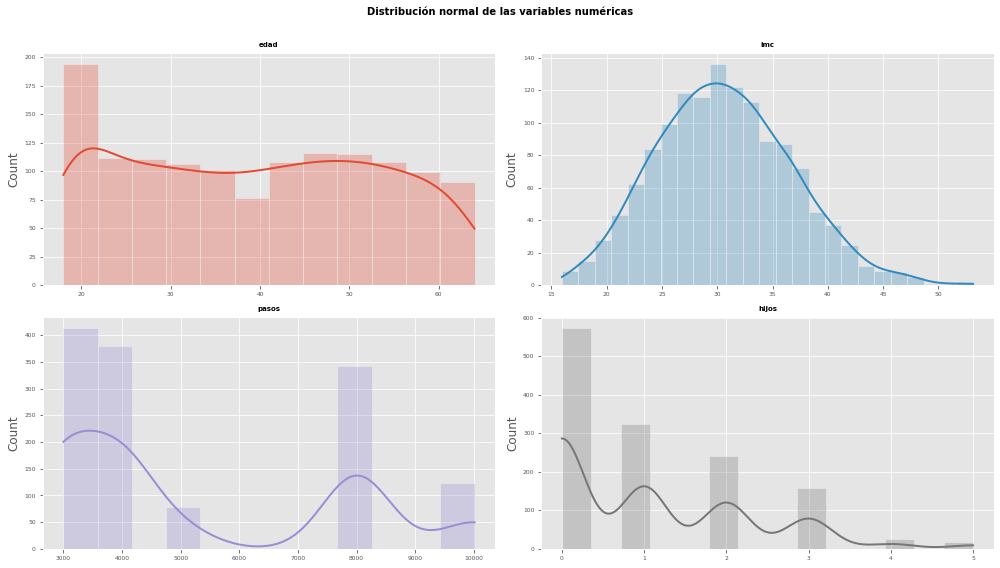

In [14]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
axes = axes.flat
columnas_numeric = df1.select_dtypes(include=['float64', 'int64']).columns
columnas_numeric = columnas_numeric.drop('cargos')

# Se establecen los parámetros de la gráfica
for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df1,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución normal de las variables numéricas', fontsize = 10, fontweight = "bold");

### Correlación variables numéricas

In [15]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = df1.select_dtypes(include=['float64', 'int64']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
7,imc,pasos,-0.681149,0.681149
11,pasos,imc,-0.681149,0.681149
22,cargos,pasos,-0.305570,0.305570
14,pasos,cargos,-0.305570,0.305570
4,edad,cargos,0.299008,0.299008
20,cargos,edad,0.299008,0.299008
21,cargos,imc,0.198341,0.198341
9,imc,cargos,0.198341,0.198341
10,pasos,edad,-0.167957,0.167957
2,edad,pasos,-0.167957,0.167957


In [16]:
corr_matrix

,edad,imc,pasos,hijos,cargos
edad,1.000000,0.109272,-0.167957,0.042469,0.299008
imc,0.109272,1.000000,-0.681149,0.012759,0.198341
pasos,-0.167957,-0.681149,1.000000,0.055346,-0.305570
hijos,0.042469,0.012759,0.055346,1.000000,0.067998
cargos,0.299008,0.198341,-0.305570,0.067998,1.000000


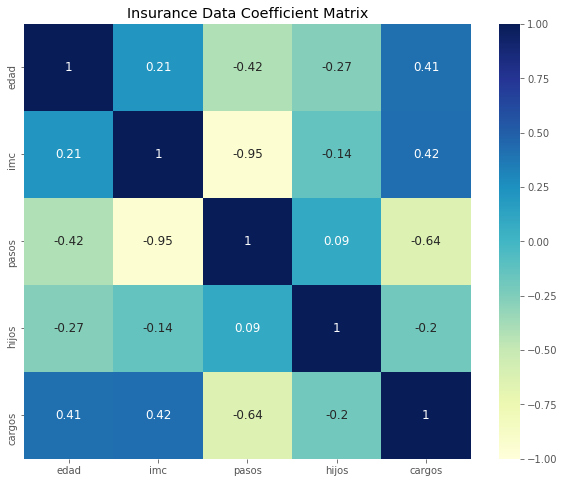

In [17]:
# Heatmap matriz de correlaciones
# Librería Matplotlib
# ==============================================================================
CoeffMatrix = corr_matrix.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(
    data=CoeffMatrix,
    annot_kws = {"size": 12},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap='YlGnBu', 
    annot=True)

plt.title('Insurance Data Coefficient Matrix')
plt.show()

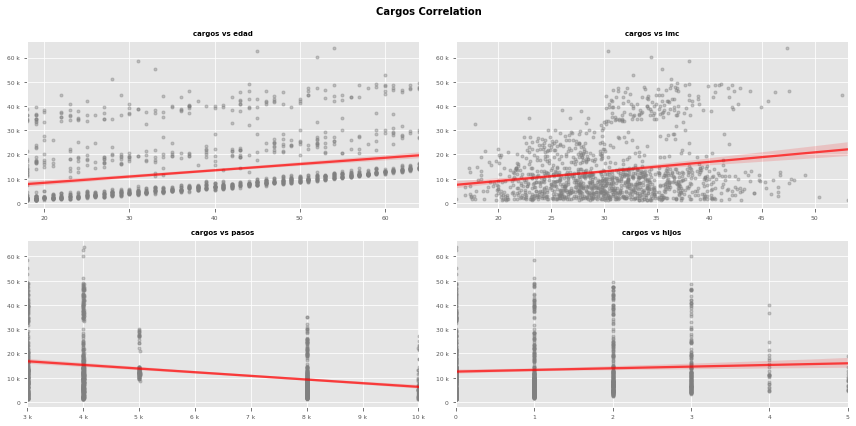

In [18]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes = axes.flat
columnas_numeric = df1.select_dtypes(include=['float64', 'int64']).columns
columnas_numeric = columnas_numeric.drop('cargos')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = df1[colum],
        y           = df['cargos'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"cargos vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
#for i in [4]:
#    fig.delaxes(axes[i])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Cargos Correlation', fontsize = 10, fontweight = "bold");

In [19]:
columnas_numeric

Index(['edad', 'imc', 'pasos', 'hijos'], dtype='object')

### Variables cualitativas

Al analizar las variables cualitativas de nuestros datos, aplicamos la función describe() sólo sobre los tipos de datos no numéricos (object).


In [20]:
# Variables cualitativas (tipo object)
# ==============================================================================
df1.select_dtypes(include=['object']).describe()

,sexo,fumador,region,fugas
count,1338,1338,1338,1338
unique,2,2,4,2
top,masc,no,southeast,si
freq,676,1064,364,783


En las gráficas siguientes debemos tener en cuenta que si existen variables que agrupen pocas observaciones en comparación con otros niveles de la misma, puede ocurrir que posteriormente en el proceso de validación cruzada, algunas particiones no contengan ninguna observación de dicha clase (varianza cero), lo cual puede dar lugar a errores. En estos casos, suele ser conveniente:

 * Eliminar las observaciones del grupo minoritario si es una variable multiclase.
 * Eliminar la variable si solo tiene dos niveles.
 * Agrupar los niveles minoritarios en un único grupo.
 * Asegurar que, en la creación de las particiones, todos los grupos estén representados en cada una de ellas.


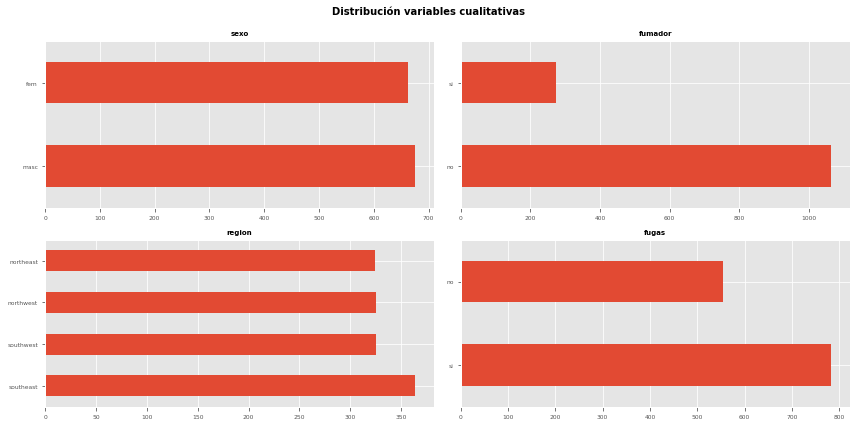

In [21]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes = axes.flat
columnas_object = df1.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    df1[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
#for i in [7, 8]:
#    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");


A continuación validamos el conteo de los valores de la variable fumador.

In [22]:
df1.fumador.value_counts().sort_index()

no    1064
si     274
Name: fumador, dtype: int64

### Análisis de la variable respuesta

Previo a la creación del modelo, es muy importante estudiar la distribución de la variable respuesta, ya que, a fin de cuentas, es lo que interesa predecir. En este caso nuestra variable respuesta resultan ser los valores almacenados en la columna _cargos_, la cual contiene los costos médicos individuales facturados por el seguro médico.

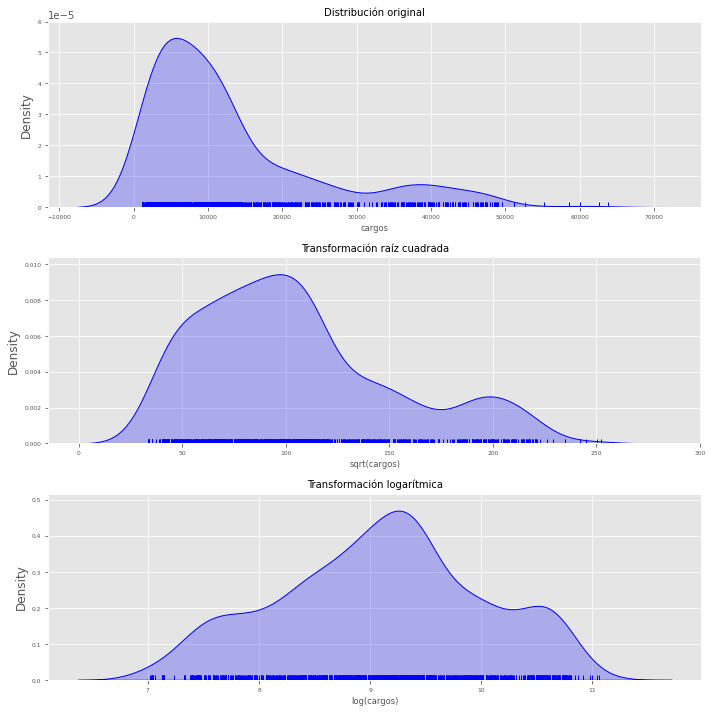

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

# Plot 1
sns.distplot(df.cargos,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('cargos', fontsize='small')
axes[0].tick_params(labelsize = 6)

# Plot 2
sns.distplot(np.sqrt(df.cargos),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(cargos)', fontsize='small')
axes[1].tick_params(labelsize = 6)

# Plot 3
sns.distplot(np.log(df.cargos),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(cargos)', fontsize='small')
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

La variable _cargos_ tiene una distribución asimétrica con una cola positiva debido a que, unas pocas viviendas, tienen un precio muy superior a la media. Este tipo de distribución suele visualizarse mejor tras aplicar el logarítmica o la raíz cuadrada.


In [24]:
print("Estadisticas descriptivas de costos médicos \n=============================================")
print(df['cargos'].describe())
print("\nasimetria:  {}".format(skew(df['cargos'])))
print("curtosis:  {}".format(kurtosis(df['cargos'])))
print("valores nulos en 'cargos': {}".format(df['cargos'].isnull().sum()))
print("valores nulos en 'fumador': {}".format(df['fumador'].isnull().sum()))

Estadisticas descriptivas de costos médicos 
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: cargos, dtype: float64

asimetria:  1.5141797118745743
curtosis:  1.595821363956751
valores nulos en 'cargos': 0
valores nulos en 'fumador': 0


In [25]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(df1.cargos, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

,sumsquare_error,aic,bic,kl_div
expon,4.181004e-09,2400.680565,-35431.424030,inf
gamma,4.198320e-09,2402.165628,-35418.695006,inf
beta,4.420575e-09,2396.752013,-35342.474858,inf
exponpow,6.519830e-09,2426.671121,-34829.755890,inf
cauchy,1.386816e-08,2506.472483,-33827.103357,inf
powerlaw,1.876866e-08,2265.781957,-33415.034820,inf
logistic,2.042614e-08,2547.313130,-33309.002673,inf
norm,2.689521e-08,2542.161430,-32940.875358,inf
chi2,7.112011e-08,519815.706946,-31632.575712,3.009276


### División de los datos en train y test